## 加载图像

array([[166.,  57., 205., 165.],
       [165., 265., 200., 373.],
       [148., 104., 171., 118.],
       [146., 312., 169., 324.]])

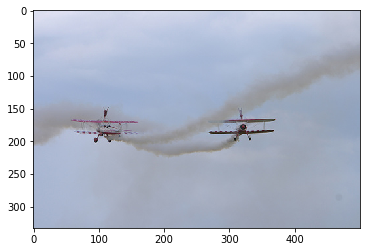

In [40]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
image_path='../data/detection/2008_007442.jpg'
annotation_path='../data/detection/2008_007442.npy'
im=cv2.imread(image_path)[...,::-1]
boxes=np.load(annotation_path)
plt.imshow(im)
boxes

## ConvertColor

In [5]:
class ConvertColor(object):
    """
    色彩空间转换
    """

    def __init__(self, current, transform):
        self.transform = transform
        self.current = current

    def __call__(self, image, gt_boxes=None, labels=None):
        """

        :param image: [H,W,3]
        :param gt_boxes: [N,(y1,x1,y2,x2)]
        :param labels: [N]
        :return:
        """
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'RGB' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif self.current == 'BGR' and self.transform == 'RGB':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        elif self.current == 'HSV' and self.transform == "RGB":
            image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
        else:
            raise NotImplementedError
        return Identity()(image, gt_boxes, labels)

    
class Identity(object):
    """
    恒等转换
    """

    def __init__(self):
        super(Identity, self).__init__()

    def __call__(self, image, gt_boxes=None, labels=None):
        if gt_boxes is None:
            return image
        return image, gt_boxes, labels

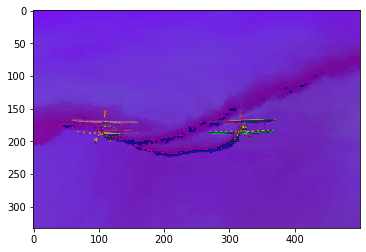

In [6]:
hsv=ConvertColor('RGB','HSV')(im)
plt.imshow(hsv)

In [73]:
np.min(hsv[:,:,0]),np.max(hsv[:,:,0])

(0, 179)

In [74]:
np.min(hsv[:,:,1]),np.max(hsv[:,:,1])

(0, 255)

In [75]:
np.min(hsv[:,:,2]),np.max(hsv[:,:,2])

(2, 243)

## Saturation

In [15]:
class Saturation(object):
    """
    改变HSV图像的饱和度
    """

    def __init__(self, factor):
        if factor <= 0.0:
            raise ValueError("It must be `factor > 0`.")
        self.factor = factor

    def __call__(self, image, gt_boxes=None, labels=None):
        image = image.copy().astype(np.float32)
        image[:, :, 1] = np.clip(image[:, :, 1] * self.factor, 0, 255)
        return Identity()(image.astype(np.uint8), gt_boxes, labels)

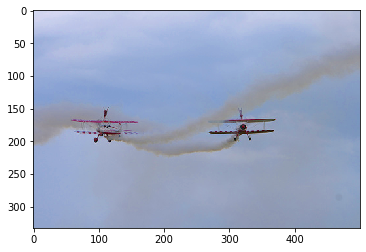

In [16]:
hsv1=Saturation(factor=1.5)(hsv)
plt.imshow(ConvertColor('HSV','RGB')(hsv1))

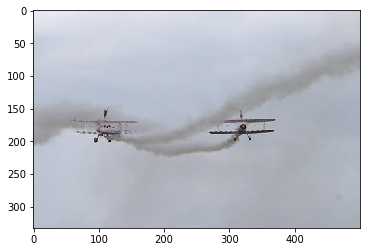

In [17]:
hsv1=Saturation(factor=0.5)(hsv)
plt.imshow(ConvertColor('HSV','RGB')(hsv1))

## Hue

In [18]:
class Hue(object):
    """
    改变颜色
    """

    def __init__(self, delta):
        if not (-180 <= delta <= 180):
            raise ValueError("`delta` must be in the closed interval `[-180, 180]`.")
        self.delta = delta

    def __call__(self, image, gt_boxes=None, labels=None):
        image = image.copy().astype(np.float32)
        image[:, :, 0] = np.clip(image[:, :, 0] + self.delta, 0, 180)
        return Identity()(image.astype(np.uint8), gt_boxes, labels)

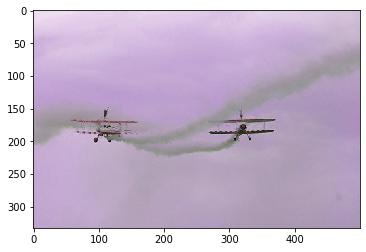

In [19]:
hsv1=Hue(delta=30)(hsv)
plt.imshow(ConvertColor('HSV','RGB')(hsv1))

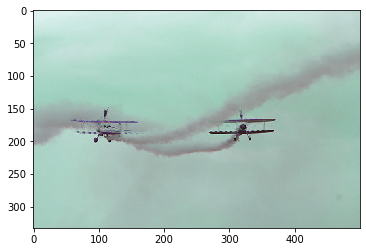

In [20]:
hsv1=Hue(delta=-30)(hsv)
plt.imshow(ConvertColor('HSV','RGB')(hsv1))

## Brightness

In [21]:
class Brightness(object):
    """
    改变RGB图像的亮度
    """

    def __init__(self, delta):
        """
        :param delta: 改变的像素值
        """
        self.delta = delta

    def __call__(self, image, gt_boxes=None, labels=None):
        image = image.copy().astype(np.float)
        image = np.clip(image + self.delta, 0, 255).astype(np.uint8)
        return Identity()(image, gt_boxes, labels)

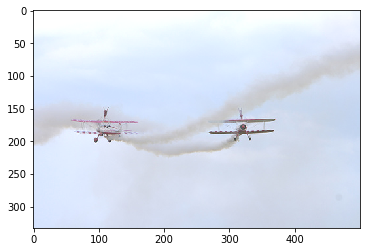

In [22]:
img = Brightness(50)(im)
plt.imshow(img)

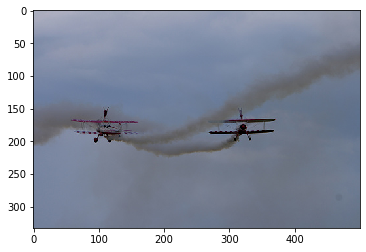

In [23]:
img = Brightness(-50)(im)
plt.imshow(img)

## Contrast

In [24]:
class Contrast(object):
    """
    改变对比度
    """

    def __init__(self, factor):
        if factor <= 0.0:
            raise ValueError("It must be `factor > 0`.")
        self.factor = factor

    def __call__(self, image, gt_boxes=None, labels=None):
        image = image.astype(np.float32)
        image = np.clip(127.5 + self.factor * (image - 127.5), 0, 255)
        return Identity()(image.astype(np.uint8), gt_boxes, labels)

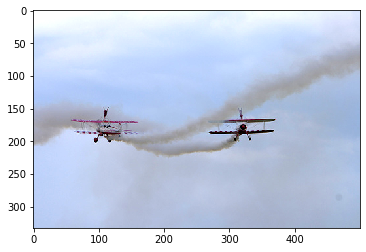

In [25]:
img = Contrast(1.5)(im)
plt.imshow(img)

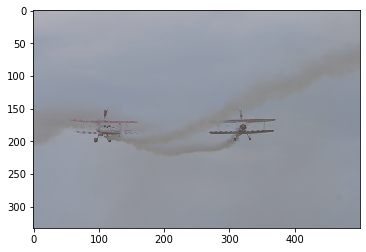

In [26]:
img = Contrast(0.5)(im)
plt.imshow(img)

## Gamma

In [27]:
class Gamma(object):
    """
    改变RGB图像的gamma值
    """

    def __init__(self, gamma):
        if gamma <= 0.0:
            raise ValueError("It must be `gamma > 0`.")
        self.gamma = gamma
        self.gamma_inv = 1.0 / gamma
        self.table = np.array([((i / 255.0) ** self.gamma_inv) * 255 for i in np.arange(0, 256)]).astype("uint8")

    def __call__(self, image, gt_boxes=None, labels=None):
        image = cv2.LUT(image, self.table)
        return Identity()(image, gt_boxes, labels)

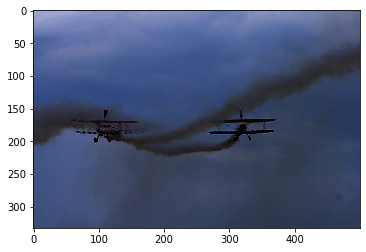

In [28]:
img = Gamma(0.3)(im)
plt.imshow(img)

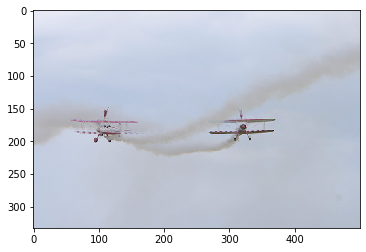

In [29]:
img = Gamma(1.5)(im)
plt.imshow(img)

## HistogramEqualization

In [30]:
class HistogramEqualization:
    """
    对HSV图像做直方图均衡化
    """

    def __init__(self):
        super(HistogramEqualization, self).__init__()

    def __call__(self, image, gt_boxes=None, labels=None):
        image[:, :, 2] = cv2.equalizeHist(image[:, :, 2])
        return Identity()(image, gt_boxes, labels)

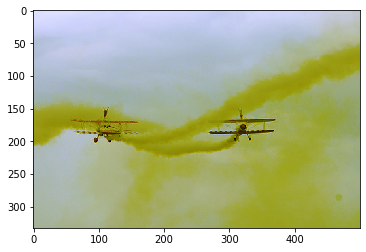

In [31]:
img = HistogramEqualization()(im)
plt.imshow(img)

## ChannelSwap

In [32]:
class ChannelSwap(object):
    """
    通道交换
    """

    def __init__(self, order):
        self.order = order

    def __call__(self, image, gt_boxes=None, labels=None):
        image = image[:, :, self.order]
        return Identity()(image, gt_boxes, labels)

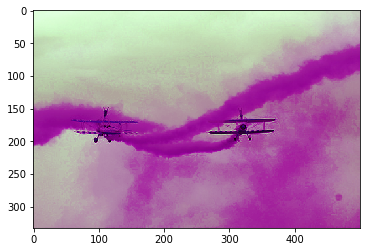

In [33]:
img = ChannelSwap([1,2,0])(im)
plt.imshow(img)

## Random

In [119]:
class RandomSaturation(object):
    def __init__(self, prob=0.5, lower=0.5, upper=1.5):
        self.prob = prob
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "saturation upper must be >= lower."
        assert self.lower >= 0, "saturation lower must be non-negative."

    def __call__(self, image, gt_boxes=None, labels=None):
        if random.random() < self.prob:
            alpha = random.uniform(self.lower, self.upper)
            return Saturation(factor=alpha)(image, gt_boxes, labels)
        return Identity()(image, gt_boxes, labels)

class RandomBrightness(object):
    def __init__(self, prob=0.5, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.prob = prob
        self.delta = delta

    def __call__(self, image, gt_boxes=None, labels=None):
        if random.random() < self.prob:
            delta = random.uniform(-self.delta, self.delta)
            return Brightness(delta)(image, gt_boxes, labels)
        return Identity()(image, gt_boxes, labels)

class RandomContrast(object):
    def __init__(self, prob=0.5, lower=0.5, upper=1.5):
        self.prob = prob
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, gt_boxes=None, labels=None):
        if random.random() < self.prob:
            alpha = random.uniform(self.lower, self.upper)
            return Contrast(factor=alpha)(image, gt_boxes, labels)
        return Identity()(image, gt_boxes, labels)
class RandomHue(object):
    def __init__(self, prob=0.5, delta=18.0):
        assert -180 <= delta <= 180, "`delta` must be in the closed interval `[-180, 180]`."
        self.delta = delta
        self.prob = prob

    def __call__(self, image, gt_boxes=None, labels=None):
        if random.random() < self.prob:
            delta = random.uniform(-self.delta, self.delta)
            return Hue(delta)(image, gt_boxes, labels)
        return Identity()(image, gt_boxes, labels)

class RandomChannelSwap(object):
    def __init__(self, prob=0.5):
        self.prob = prob
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, gt_boxes=None, labels=None):
        if random.random() < self.prob:
            i=np.random.randint(0, len(self.perms))
            print("i:{}".format(i))
            order = self.perms[i]
            return ChannelSwap(order)(image, gt_boxes, labels)
        return Identity()(image, gt_boxes, labels)


## PhotometricDistort

In [120]:
class Compose(object):
    """
    组合多个转换
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, gt_boxes=None, labels=None):
        for t in self.transforms:
            if gt_boxes is not None:
                img, gt_boxes, labels = t(img, gt_boxes, labels)
            else:
                img = t(img)
        return img, gt_boxes, labels
class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),  # RGB
            ConvertColor(current="RGB", transform='HSV'),  # HSV
            RandomSaturation(),  # HSV
            RandomHue(),  # HSV
            ConvertColor(current='HSV', transform='RGB'),  # RGB
            RandomContrast()  # RGB
        ]
        self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomChannelSwap()

    def __call__(self, image, boxes=None, labels=None):
        im = image.copy()
        im, boxes, labels = self.rand_brightness(im, boxes, labels)
        if random.random() < 0.5:
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, boxes, labels = distort(im, boxes, labels)
        return self.rand_light_noise(im, boxes, labels)

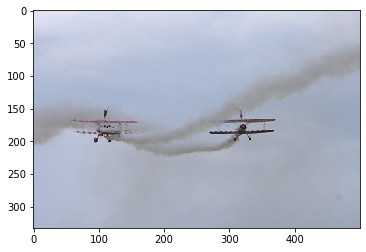

In [170]:
img,_,_ = PhotometricDistort()(im,[],[])
plt.imshow(img)

In [52]:
random.randint(2,3)

2